## Sample Complexity and Sample Size

Sample Complexity:
$H_{\epsilon}=\frac{1}{2(\mu_2-\mu_1+\epsilon)^2}+\sum^K_{i=2}\frac{1}{2(\mu_1-\mu_i+\epsilon)^2}$

Sample Size:
$H_{\epsilon}\log(1/\delta)$

In [1]:
import math
from itertools import product
import numpy as np

def sample_complexity(mu, eps):
    x_1 = 1 / (2 * ((mu[0] - mu[1] + eps) ** 2))
    x_2 = []

    if len(mu) >= 2:
        for _mu in mu[1:]:
            _x = 1 / (2 * ((mu[0] - mu[1] + eps) ** 2))
            x_2.append(_x)
    return x_1 + sum(x_2)

def sample_size(_sample_complexity, _delta):
    return _sample_complexity * np.log(1/_delta)



In [2]:
mu = (0.1, 0.3)

print("(ε,δ)")
for eps, delta in product([0.001, 0.005, 0.01, 0.05, 0.1], [0.001, 0.005, 0.01, 0.05, 0.1]):
    print(f"({eps},{delta})\t\t/サンプル数{round(sample_size(sample_complexity(mu, eps), _delta=delta))}")

(ε,δ)
(0.001,0.001)		/サンプル数174
(0.001,0.005)		/サンプル数134
(0.001,0.01)		/サンプル数116
(0.001,0.05)		/サンプル数76
(0.001,0.1)		/サンプル数58
(0.005,0.001)		/サンプル数182
(0.005,0.005)		/サンプル数139
(0.005,0.01)		/サンプル数121
(0.005,0.05)		/サンプル数79
(0.005,0.1)		/サンプル数61
(0.01,0.001)		/サンプル数191
(0.01,0.005)		/サンプル数147
(0.01,0.01)		/サンプル数128
(0.01,0.05)		/サンプル数83
(0.01,0.1)		/サンプル数64
(0.05,0.001)		/サンプル数307
(0.05,0.005)		/サンプル数235
(0.05,0.01)		/サンプル数205
(0.05,0.05)		/サンプル数133
(0.05,0.1)		/サンプル数102
(0.1,0.001)		/サンプル数691
(0.1,0.005)		/サンプル数530
(0.1,0.01)		/サンプル数461
(0.1,0.05)		/サンプル数300
(0.1,0.1)		/サンプル数230


In [3]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from itertools import accumulate

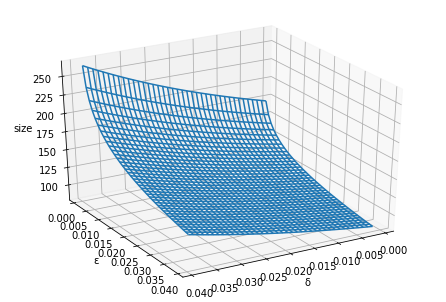

In [4]:
def sample_size_func(x, y):
    return sample_size(sample_complexity(mu, x), _delta=y)

delta = np.arange(0.001, 0.04, 0.001)
eps = np.arange(0.001, 0.04, 0.001)

D, E = np.meshgrid(delta, eps)
Z = sample_size_func(D, E)

fig = plt.figure()
ax = Axes3D(fig)

ax.set_xlabel("δ")
ax.set_ylabel("ε")
ax.set_zlabel("size")

ax.plot_wireframe(D, E, Z, cmap='ocean')
ax.view_init(elev=30, azim=60)
plt.show()


$\beta(n, \delta)=\log\frac{4Kn^2}{\delta}$で

Upper Confidence Bound:  $\overline{\mu}_{i,n}=\hat{\mu}_{i,n} + \sqrt{\frac{\beta(n, \delta)}{2n}}$

Lower Confidence Bound:  $\underline{\mu}_{i,n}=\hat{\mu}_{i,n} + \sqrt{\frac{\beta(n, \delta)}{2n}}$

In [5]:
def upper_confidence_bound(_beta, hat_mu, n):
    return hat_mu + np.sqrt(_beta / (2 * n))

def lower_confidence_bound(_beta, hat_mu, n):
    return hat_mu - np.sqrt(_beta / (2 * n))

def beta(n, delta, K):
    return np.log2(4*K*(n**2)/delta)


実験すると、このサンプルサイズの決め方では収束しないことがわかってきたので、10倍するなどして様子を見てみる

In [6]:
arms = (0.1, 0.15)
eps = 0.02
delta = 0.05

K = sample_size(sample_complexity(mu=arms, eps=eps), _delta=delta)
K = round(K) * 10

print(f"sample size: {K}, confidence: {1 - delta}")


record = [np.zeros(len(arms))]
accumlation = np.zeros(len(arms))
for n in range(1, K):
    results = [np.random.binomial(n=1, p=a) for a in arms]
    accumlation += results
    record.append(results)

    mu = accumlation / n
    hat_i_star = np.argmax(results)
    ucbs = [upper_confidence_bound(beta(n=n, delta=delta, K=K), hat_mu=hat_mu, n=n) for hat_mu in mu]
    lcbs = [lower_confidence_bound(beta(n=n, delta=delta, K=K), hat_mu=hat_mu, n=n) for hat_mu in mu]

    if lcbs[hat_i_star] + eps > max(ucbs[0:hat_i_star]+ucbs[hat_i_star+1:]):
        print('done')
        print(f"{lcbs[hat_i_star] + eps} > {max(ucbs[0:hat_i_star]+ucbs[hat_i_star+1:])}")
        print(f"best arm {hat_i_star}, trial: {n}")
        break
    elif len(list(filter(lambda ucb: lcbs[hat_i_star] > ucb, ucbs))) > 0:
        print('remove process')  # 本当はここで削除処理が入ることがあるが、一旦これで
        pass


sample size: 33290, confidence: 0.95
done
0.1348146899657993 > 0.1347886503264763
best arm 1, trial: 23950


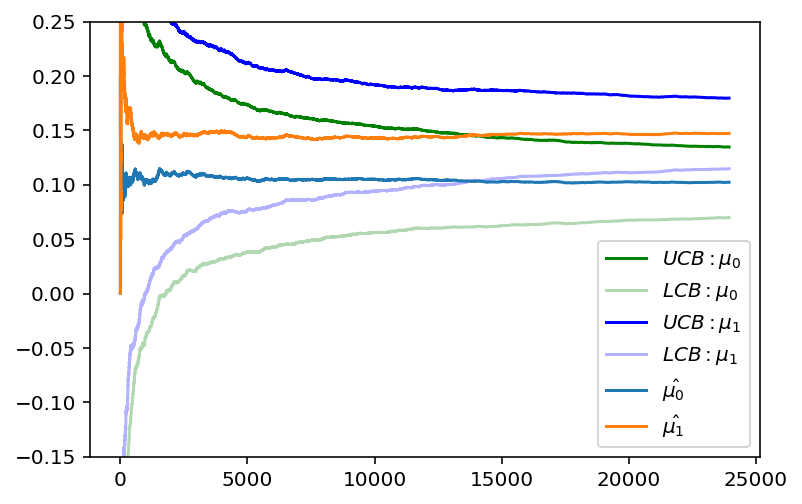

In [7]:
%config InlineBackend.figure_formats = {'png', 'retina'}

res = list(accumulate(record, lambda x, y: np.array(x) + np.array(y)))
plt.plot([i for i, _ in enumerate(res)], [upper_confidence_bound(beta(n+1, delta, K), r[0]/(n+1), n+1) for n, r in enumerate(res)], 'green', label='$UCB:\mu_0$')
plt.plot([i for i, _ in enumerate(res)], [lower_confidence_bound(beta(n+1, delta, K), r[0]/(n+1), n+1) for n, r in enumerate(res)], 'green', label='$LCB:\mu_0$', alpha=0.3)

plt.plot([i for i, _ in enumerate(res)], [upper_confidence_bound(beta(n+1, delta, K), r[1]/(n+1), n+1) for n, r in enumerate(res)], 'blue', label='$UCB:\mu_1$')
plt.plot([i for i, _ in enumerate(res)], [lower_confidence_bound(beta(n+1, delta, K), r[1]/(n+1), n+1) for n, r in enumerate(res)], 'blue', label='$LCB:\mu_1$', alpha=0.3)

plt.plot([i for i, _ in enumerate(res)], [r[0]/(n+1) for n, r in enumerate(res)], label='$\hat{\mu_0}$')
plt.plot([i for i, _ in enumerate(res)], [r[1]/(n+1) for n, r in enumerate(res)], label='$\hat{\mu_1}$')

plt.ylim([-0.15, 0.25])
plt.legend()

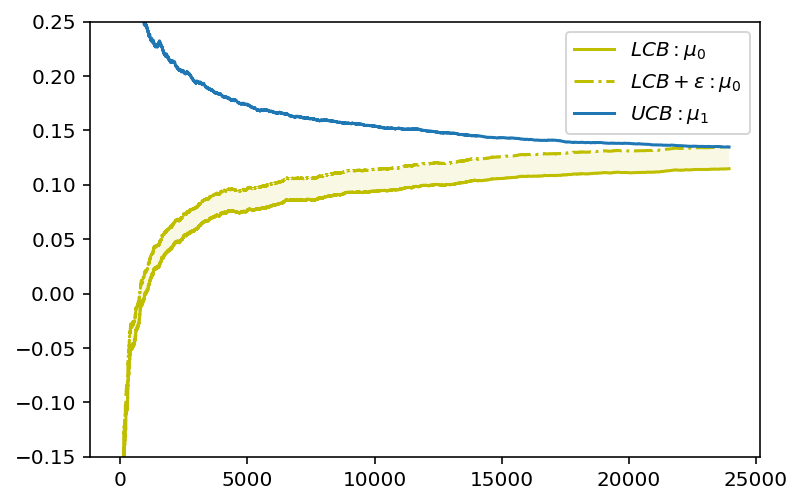

In [8]:
plt.plot([i for i, _ in enumerate(res)], [lower_confidence_bound(beta(n+1, delta, K), r[1]/(n+1), n+1) for n, r in enumerate(res)], label='$LCB:\mu_0$', color='y')
plt.plot([i for i, _ in enumerate(res)], [lower_confidence_bound(beta(n+1, delta, K), r[1]/(n+1), n+1) + eps for n, r in enumerate(res)], label='$LCB+\epsilon:\mu_0$', color='y', linestyle='dashdot')
plt.fill_between(
    [i for i, _ in enumerate(res)], 
    [lower_confidence_bound(beta(n+1, delta, K), r[1]/(n+1), n+1) + eps for n, r in enumerate(res)], 
    [lower_confidence_bound(beta(n+1, delta, K), r[1]/(n+1), n+1) for n, r in enumerate(res)],
    facecolor='y',alpha=0.1)

plt.plot([i for i, _ in enumerate(res)], [upper_confidence_bound(beta(n+1, delta, K), r[0]/(n+1), n+1) for n, r in enumerate(res)], label='$UCB:\mu_1$')

plt.ylim([-0.15, 0.25])
plt.legend()